In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from qutip import *

### Introduction

The Hamiltonian for a Transmon qubit is

$\displaystyle H = \sum_n 4 E_C (n_g - n)^2 \left|n\right\rangle\left\langle n\right| - E_{J\Sigma} [\cos(\pi \Phi/\Phi_0)\cos(\theta) + d \sin(\pi \Phi/\Phi_0)\sin(\theta)]$

$\displaystyle H = \sum_n 4 E_C (n_g - n)^2 \left|n\right\rangle\left\langle n\right| - E_{J\Sigma}[\cos(\pi \Phi/\Phi_0)\frac{1}{2}\sum_n\left(\left|n+1\right\rangle\left\langle n\right| + \left|n\right\rangle\left\langle n+1\right| \right)+i d \sin(\pi \Phi/\Phi_0)\frac{1}{2}\sum_n\left(\left|n+1\right\rangle\left\langle n\right| - \left|n\right\rangle\left\langle n+1\right| \right)]$

where $E_C$ is the charge energy, $E_J$ is the Josephson energy, and $\left| n\right\rangle$ is the charge state with $n$ Cooper-pairs on the island that makes up the charge qubit.

### Qubit parameters

In [3]:
class SystemParameters:
    
    def __init__(self):
        # Input variable
        
        self.init_system()
        self.init_operators()
        
    def init_system(self):
        self.initial_pulse = True
        self.state_num = 3
        self.alpha = 0.3
        self.freq_ge = 5 #GHz
        self.ens = np.array([ 2*np.pi*ii*(self.freq_ge - 0.5*(ii-1)*self.alpha) for ii in np.arange(self.state_num)])
        self.pts_per_period = 20
        self.dt = (1./self.freq_ge)/self.pts_per_period
        self.total_time=200.
        self.steps = int(self.total_time/self.dt)+1
        self.tlist = np.linspace(0,self.total_time,self.steps)
        
    def update_total_time(self,total_time):
        self.total_time=total_time
        self.steps = int(self.total_time/self.dt)+1
        self.tlist = np.linspace(0,self.total_time,self.steps)
        
    def update_pts_per_period(self,pts_per_period):
        self.pts_per_period=pts_per_period
        self.dt = (1./self.freq_ge)/self.pts_per_period
        self.steps = int(self.total_time/self.dt)+1
        self.tlist = np.linspace(0,self.total_time,self.steps)
        
    def init_operators(self):
        # Create operator matrix in numpy array
        
        
        self.drive_freq = self.ens[1]
        
        x   = np.diag(np.sqrt(np.arange(1,self.state_num)),1)+np.diag(np.sqrt(np.arange(1,self.state_num)),-1)
        y   = (0+1j) *(np.diag(np.sqrt(np.arange(1,self.state_num)),1)-np.diag(np.sqrt(np.arange(1,self.state_num)),-1))
        
        self.ops = [x,y]
        
        self.Hx_op = x
        self.Hy_op = y
        
        self.ops_len = len(self.ops)
       
    def state_operators(self):
        # State operators, used for output
        g_array= np.zeros(sys_para.state_num)
        g_array[0] = 1
        g_vector = Qobj(np.array(g_array))
        g_matrix = Qobj(np.diag(g_array))

        e_array= np.zeros(sys_para.state_num)
        e_array[1] = 1
        e_vector = Qobj(np.array(e_array))
        e_matrix = Qobj(np.diag(e_array))

        f_array= np.zeros(sys_para.state_num)
        f_array[2] = 1
        f_vector = Qobj(np.array(f_array))
        f_matrix = Qobj(np.diag(f_array))


        self.gm = g_matrix
        self.em = e_matrix
        self.fm = f_matrix
        
        self.gs = g_vector
        self.es = e_vector
        self.fs = f_vector

        return [self.gm,self.em,self.fm]
    
    
    def c_operators(self):
        # qubit coherence parameters

        T1_ge = 18000.0
        T1_ef = 7000.0
        T2_ge = 2000.0
        T2_ef = 2000.0
        T_ephi = 1/(1/T2_ge -1/(2*T1_ge))
        T_fphi = 1/(1/T2_ef -1/(2*T1_ef))

        c_ops = (1/T1_ge)*lindblad_dissipator(self.gs*self.es.dag()) +   (1/T1_ef)*lindblad_dissipator(self.es*self.fs.dag()) +\
        (2/(T_ephi))*lindblad_dissipator(self.es*self.es.dag()) + (2/(T_fphi))*lindblad_dissipator(self.fs*self.fs.dag()) 
        
        return c_ops
    
    def time_to_index(self,time):
        return int(time/self.dt - 1)

In [4]:
class H_Pulse:
    def __init__(self, sys_para):
        self.sys_para = sys_para
        self.tlist = self.sys_para.tlist
        self.pulse_coeff_array = np.zeros(len(self.tlist))
        
    def gauss_span_length(self,length):
        return 4*length

    def square_span_length(self,length):
        ramp_sigma = 10
        return length + 4*ramp_sigma

    def gauss(self,tlist,time,amp,freq,length,phase):
        span_length = self.gauss_span_length(length)
        t0 = time+0.5*span_length
        return amp*np.exp(-(tlist-t0)**2/(2*length**2)) * (tlist>time) * (tlist< (time+span_length)) *\
        np.sin(2*np.pi*freq*tlist + phase)

    def add_pulse(self,time,amp,freq,length,phase,ptype):
        self.pulse_coeff_array += self.gauss(self.tlist,time,amp,freq,length,phase)
        return time + self.gauss_span_length(length)
    
    def add_arb_pulse(self,arb_pulse):
        c = self.pulse_coeff_array.copy()
        c[:len(arb_pulse)] += arb_pulse
        self.pulse_coeff_array = c
        
    def get_coeff(self,time):
        index = self.sys_para.time_to_index(time)
        return self.pulse_coeff_array[index]
    
    

In [5]:
def plot_result(output,sys_para):
    # Plotting
    g_out = output.expect[0]
    e_out= output.expect[1]
    f_out = output.expect[2]

    fig, axes = plt.subplots(1, 1, figsize=(10,6))

    axes.plot(sys_para.tlist, g_out, label="g")
    axes.plot(sys_para.tlist, e_out, label="e")
    axes.plot(sys_para.tlist, f_out, label="f")
    axes.legend(loc=0)
    axes.set_xlabel('Time')
    axes.set_ylabel('Occupation probability')

In [6]:
def plot_sweep_result(p_g,p_e,tlist,sweep):
    plt.figure(figsize=(20,8))

    plt.subplot(121, title="g")

    plt.pcolormesh(tlist,sweep, np.array(p_g))
    plt.xlabel('Time')

    plt.subplot(122, title="e")

    plt.pcolormesh(tlist,sweep, np.array(p_e))
    plt.xlabel('Time')

### GRAPE pulse simulation

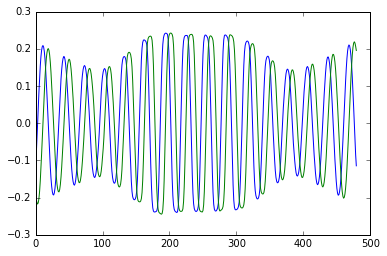

In [7]:
control_pulse = np.load("data/drag-control.npy")
plt.plot(control_pulse[0])
plt.plot(control_pulse[1])

In [10]:
def GRAPE_pulse(sys_para):
    # Define pulses
    Hx_pulse = H_Pulse(sys_para)
    Hy_pulse = H_Pulse(sys_para)

    control_pulse = np.load("data/drag-control.npy")
    
    Hx_pulse.add_arb_pulse(control_pulse[0])
    Hy_pulse.add_arb_pulse(control_pulse[1])

        
    fig, axes = plt.subplots(1, 1, figsize=(10,6))
    plt.plot(sys_para.tlist,Hx_pulse.pulse_coeff_array)
    plt.plot(sys_para.tlist,Hy_pulse.pulse_coeff_array)
    axes.set_title('Input Pulse')

    # Get Hamiltonian pulse value at time t
    def Hx_coeff(t,args=None):
        Hx_t = Hx_pulse.get_coeff(t)
        return Hx_t

    def Hy_coeff(t,args=None):
        Hy_t = Hy_pulse.get_coeff(t)
        return Hy_t

    # Hamiltonian
    H0 = Qobj(np.diag(sys_para.ens))
    Hx = Qobj(sys_para.Hx_op)
    Hy = Qobj(sys_para.Hy_op)
    H_t = [H0, [Hx,Hx_coeff], [Hy,Hy_coeff]]
    
    state_ops = sys_para.state_operators()
    c_ops = sys_para.c_operators()

    # Run Simulation
    psi0 = state_ops[0] # start in ground cavity and excited transmon
    output = mesolve(H_t, psi0, sys_para.tlist, c_ops, state_ops ,progress_bar=True)
    clear_output()

    plot_result(output,sys_para)
    fidelity = output.expect[1][sys_para.steps-1]
    print "Pi-pulse: " + str(fidelity)
    
    return (output,fidelity)

Pi-pulse: 0.000537908118409


(Result object with mesolve data.
 --------------------------------
 expect = True
 num_expect = 3, num_collapse = 0, 0.00053790811840924381)

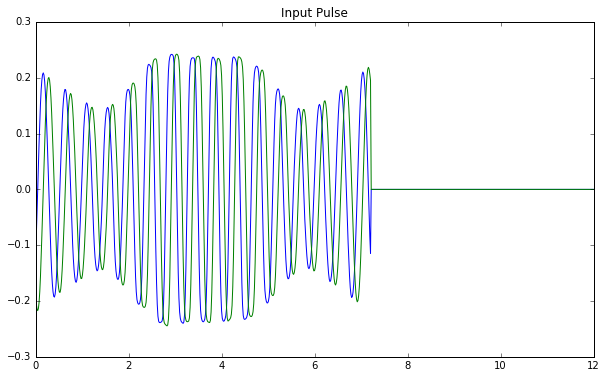

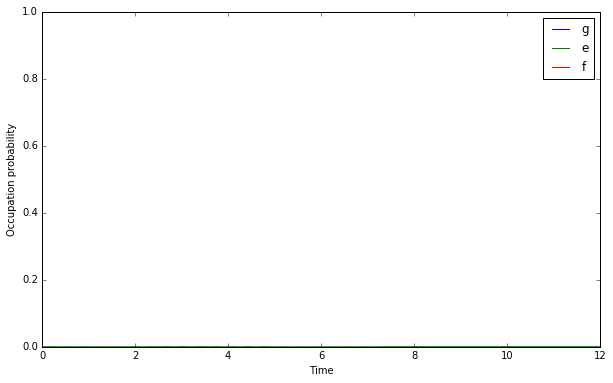

In [19]:
sys_para = SystemParameters()
sys_para.update_total_time(12)
sys_para.update_pts_per_period(13.3)
GRAPE_pulse(sys_para)